# Reduced Electron Velocity Distribution Function using Monte-Carlo integration

author: Louis Richard\
Example to compute and plot reduced electron distributions from FPI (based on Khotyaintsev et al., 2020, PRL)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from pyrfu import mms, pyrf
from pyrfu.plot import plot_spectr, plot_line, plot_contour

mms.db_init(default="local", local="/Volumes/mms")

Load IGRF coefficients ...


[29-Jan-26 16:32:05] INFO: Updating MMS data access configuration in /Users/louisr/Dropbox/Documents/irfu-python/.venv/lib/python3.14/site-packages/pyrfu/mms/config.json...
[29-Jan-26 16:32:05] INFO: Updating MMS SDC credentials in /Users/louisr/.config/python_keyring...


## Load data

### Define time interval and spacecraft index

In [2]:
tint = ["2015-12-02T01:14:55.500", "2015-12-02T01:14:56.600"]
tint_long = ["2015-12-02T01:14:45.500", "2015-12-02T01:15:02.500"]
mms_id = 4

### Get magnetic field in spacecraft coordinates

In [3]:
b_dmpa = mms.get_data("b_dmpa_fgm_brst_l2", tint_long, mms_id)

[29-Jan-26 16:32:05] INFO: Loading mms4_fgm_b_dmpa_brst_l2...


### Get electric field in spacecraft coordinates and spacecraft potential

In [4]:
e_dsl = mms.get_data("e_dsl_edp_brst_l2", tint_long, mms_id)
scpot = mms.get_data("v_edp_brst_l2", tint_long, mms_id)

[29-Jan-26 16:32:05] INFO: Loading mms4_edp_dce_dsl_brst_l2...
[29-Jan-26 16:32:05] INFO: Loading mms4_edp_scpot_brst_l2...


### Get the electron velocity distribution skymap and the uncertainties ($\delta f / f = 1/\sqrt{n}$ with $n$ the number of counts)

In [5]:
vdf_e = mms.get_data("pde_fpi_brst_l2", tint_long, mms_id)
vdf_e_err = mms.get_data("pderre_fpi_brst_l2", tint_long, mms_id)

[29-Jan-26 16:32:05] INFO: Loading mms4_des_dist_brst...
[29-Jan-26 16:32:06] INFO: Loading mms4_des_disterr_brst...


### Define coordinates

In [6]:
x_hat = pyrf.resample(b_dmpa, vdf_e)
x_hat.data /= pyrf.norm(x_hat).data[:, np.newaxis]
z_hat = pyrf.ts_vec_xyz(
    vdf_e.time.data, np.array([0, 0, 1]) * np.ones((len(vdf_e.time), 3))
)
y_hat = pyrf.cross(z_hat, x_hat)
y_hat.data /= pyrf.norm(y_hat).data[:, np.newaxis]
z_hat = pyrf.cross(x_hat, y_hat)
z_hat.data /= pyrf.norm(z_hat).data[:, np.newaxis]

### Create transformation matrix

In [7]:
xyz = np.transpose(np.stack([x_hat.data, y_hat.data, z_hat.data]), [1, 2, 0])
xyz = pyrf.ts_tensor_xyz(vdf_e.time.data, xyz)

### Define velocity grid parallel to the magnetic field

In [8]:
vpara_lim = np.array([-10e3, 10e3], dtype=np.float64)
vg_para = np.linspace(vpara_lim[0], vpara_lim[1], 100)

### Reduce distribution along the magnetic field

In [9]:
f1dpara = mms.reduce(
    vdf_e, dim="1d", xyz=xyz, n_mc=200, vg=vg_para * 1e3, sc_pot=scpot, lower_e_lim=30.0
)
f1dpara = f1dpara.assign_coords(vx=f1dpara.vx.data / 1e3)

100%|█████████████████████| 566/566 [00:16<00:00, 33.32it/s]


### Plot

[29-Jan-26 16:32:25] WARNING: <>:6: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.

[29-Jan-26 16:32:25] WARNING: <>:6: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.

[29-Jan-26 16:32:25] WARNING: /var/folders/z6/4tzcn4qs67j8glvrfvkzlkg80000gn/T/ipykernel_79513/1363605046.py:6: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  axs[0].set_ylabel("$B_{dmpa}~[\mathrm{nT}]$")



(np.float64(16771.05203125), np.float64(16771.05204398148))

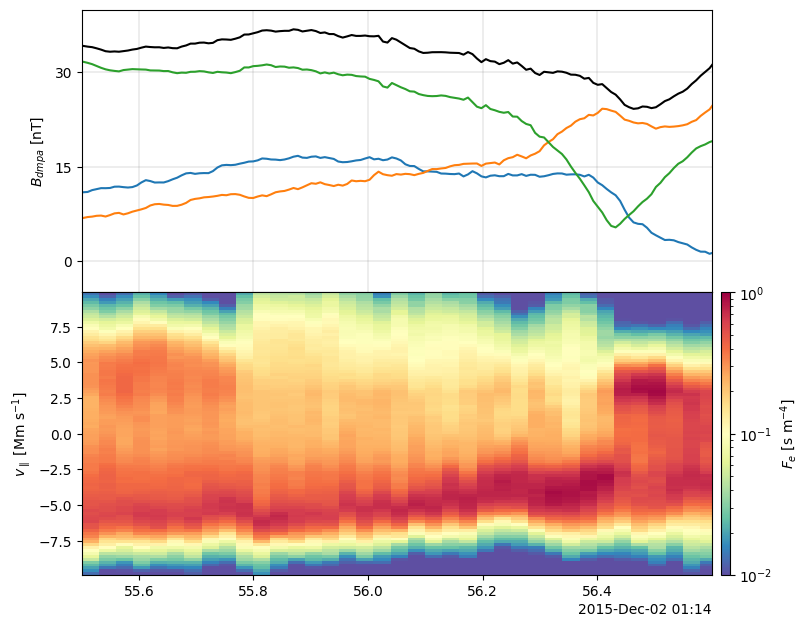

In [10]:
f, axs = plt.subplots(2, sharex="all", figsize=(9, 6.5))
f.subplots_adjust(hspace=0.0, left=0.15, right=0.85, bottom=0.08, top=0.95)
plot_line(axs[0], b_dmpa)
plot_line(axs[0], pyrf.norm(b_dmpa), color="k")
axs[0].set_ylim([-5, 40])
axs[0].set_ylabel("$B_{dmpa}~[\mathrm{nT}]$")

axs[1], cax1 = plot_spectr(
    axs[1], f1dpara, cscale="log", clim=[1e-2, 1e0], cmap="Spectral_r"
)
axs[1].set_ylim([-9.9, 9.9])
axs[1].set_ylabel("$v_\\parallel~[\\mathrm{Mm}~\\mathrm{s}^{-1}]$")
cax1.set_ylabel("$F_e~[\\mathrm{s}~\\mathrm{m}^{-4}]$")

axs[-1].set_xlim(pyrf.iso86012datetime64(np.array(tint)))

### 

## 2D projection of the ion velocity distribution functions

### Define times for 2D projection

In [11]:
t = [
    "2015-12-02T01:15:02.020000000",
    "2015-12-02T01:14:56.440",
    "2015-12-02T01:14:56.380",
    "2015-12-02T01:14:56.290",
    "2015-12-02T01:14:55.810",
    "2015-12-02T01:14:55.600",
]

### Define rotation matrix

In [12]:
x_hat = pyrf.resample(b_dmpa, vdf_e)
x_hat.data /= pyrf.norm(pyrf.resample(b_dmpa, vdf_e)).data[:, np.newaxis]
y_hat = pyrf.resample(pyrf.cross(e_dsl, b_dmpa), vdf_e)
y_hat.data /= pyrf.norm(y_hat).data[:, np.newaxis]
z_hat = pyrf.cross(x_hat, y_hat)

### Reduce ion distributions in 2d plane $(B,E\times B)$

In [13]:
f2d = []

for t_ in t:
    t_ = pyrf.extend_tint([t_, t_], [-0.06, 0.06])
    tmp = mms.reduce(
        pyrf.time_clip(vdf_e, t_),
        xyz=pyrf.time_clip(xyz, t_),
        dim="2d",
        base="cart",
        n_mc=200 * 5,
        vg=vg_para * 1e3,
    )
    f2d.append(tmp.assign_coords(vx=tmp.vx.data / 1e3, vy=tmp.vy.data / 1e3))

100%|█████████████████████████| 4/4 [00:02<00:00,  1.45it/s]


### Plot

Text(0.02, 0.5, '$v_{E\\times B}~[\\mathrm{Mm}~\\mathrm{s}^{-1}]$')

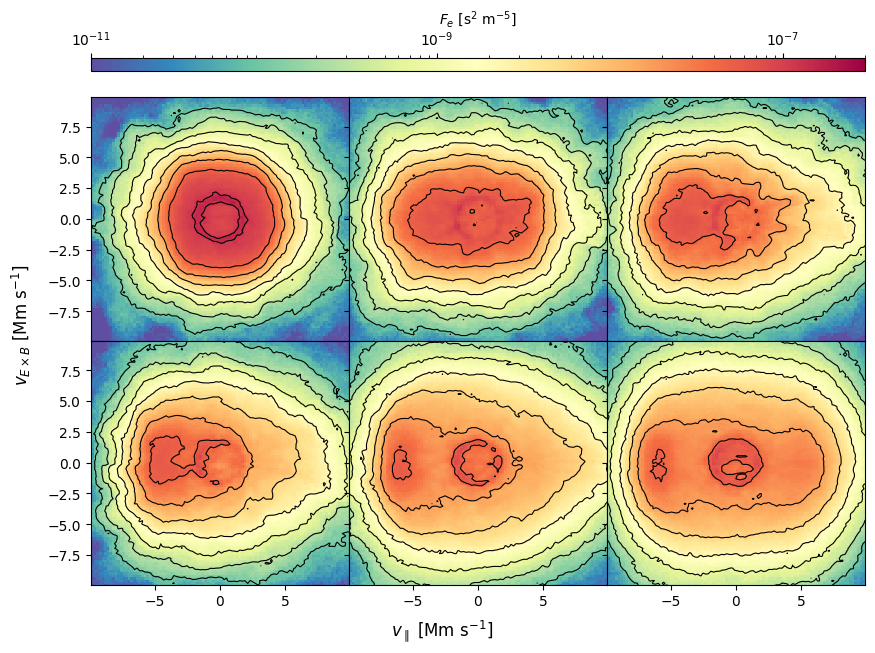

In [14]:
f, axs = plt.subplots(2, 3, sharex="all", sharey="all", figsize=(9, 6.5))
f.subplots_adjust(wspace=0, hspace=0, left=0.11, right=0.97, bottom=0.1, top=0.85)


axs[0, 0], cax0 = plot_spectr(
    axs[0, 0],
    f2d[0].mean(axis=0),
    cscale="log",
    clim=[1e-11, 3e-7],
    cmap="Spectral_r",
    colorbar="top",
)
plot_contour(
    axs[0, 0],
    f2d[0].mean(axis=0),
    levels=np.logspace(-10, -6, 10),
    colors="k",
    linewidths=0.8,
)
axs[0, 0].set_xlim([-1e4, 1e4])
axs[0, 0].set_ylim([-1e4, 1e4])


for f_2d, ax in zip(f2d[1:], axs.flatten()[1:]):
    ax = plot_spectr(
        ax,
        f_2d.mean(axis=0),
        cscale="log",
        clim=[1e-11, 3e-7],
        cmap="Spectral_r",
        colorbar="none",
    )
    plot_contour(
        ax,
        f_2d.mean(axis=0),
        levels=np.logspace(-10, -6, 10),
        colors="k",
        linewidths=0.8,
    )
    ax.set_xlim([-9.9, 9.9])
    ax.set_ylim([-9.9, 9.9])

pos_axs02 = axs[0, 2].get_position()
pos_cax0 = cax0.get_position()
x0 = pos_cax0.x0
y0 = pos_cax0.y0 + 0.03
width = pos_axs02.x0 + pos_axs02.width - pos_cax0.x0
height = 0.02
cax0.set_position([x0, y0, width, height])
cax0.set_xlabel("$F_e~[\\mathrm{s}^2~\\mathrm{m}^{-5}]$")

f.supxlabel("$v_{\\parallel}~[\\mathrm{Mm}~\\mathrm{s}^{-1}]$")
f.supylabel("$v_{E\\times B}~[\\mathrm{Mm}~\\mathrm{s}^{-1}]$")